In [1]:
import sys
sys.path.insert(0, "../../")
import torch
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

# Reweighing based on proximity

In [66]:
t = torch.linspace(0, 4 * torch.pi, 100)


def f(t):
    noise = torch.randn(100) * 0.1
    return torch.sin(t) + noise


x = f(t)


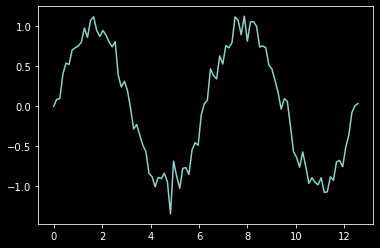

In [67]:
plt.plot(t, x)


In [68]:
# initialize a convolution
conv = torch.nn.Conv1d(1, 1, 8)

# build a gaussian kernel
n = torch.distributions.normal.Normal(0, 1)
v = torch.arange(-4, 4)
gaussian = torch.exp(n.log_prob(v))[None, None, :]

# replace the random weights
d = conv.state_dict()
d["weight"] = gaussian
conv.load_state_dict(d)
x_ = conv(x[None, None, :])[0][0]


Text(0.5, 1.0, 'smoothed')

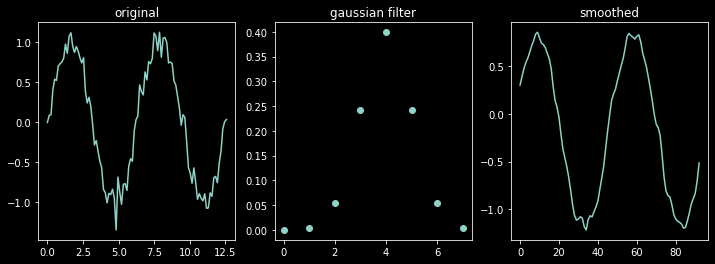

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(t, x)
ax[0].set_title("original")

ax[1].scatter([*range(8)], gaussian[0][0])
ax[1].set_title("gaussian filter")

ax[2].plot(x_.detach())
ax[2].set_title("smoothed")


# Text

In [299]:
from src.models import tokenizer

corpus = ["ik zit op de bank", "ik werk bij de bank", "bij de bank is het heel druk"]
v = tokenizer.build_vocab(corpus)


In [300]:
v["bank"], v["test"], len(v)


(6, 1, 13)

In [301]:
x = tokenizer.tokenize(corpus, v)
x


tensor([[ 2,  3,  4,  5,  6,  0,  0],
        [ 2,  7,  8,  5,  6,  0,  0],
        [ 8,  5,  6,  9, 10, 11, 12]])

In [302]:
x.shape


torch.Size([3, 7])

In [303]:
import torch.nn as nn

emb = nn.Embedding(num_embeddings=len(v), embedding_dim=4, padding_idx=0)


In [304]:
embeddings = emb(x)
embeddings.shape


torch.Size([3, 7, 4])

In [305]:
embeddings


tensor([[[-0.8782, -0.3745,  0.2675,  1.5011],
         [ 0.5722,  1.0548,  1.2089, -0.0361],
         [-0.1734,  0.7151, -0.2989, -1.7410],
         [-1.0735,  2.1103, -0.3268,  0.2082],
         [ 1.1228, -1.7430, -0.6168,  2.3689],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[-0.8782, -0.3745,  0.2675,  1.5011],
         [-0.1111, -0.4283, -0.7370, -1.0457],
         [ 0.9173,  0.1974,  0.3309, -1.7168],
         [-1.0735,  2.1103, -0.3268,  0.2082],
         [ 1.1228, -1.7430, -0.6168,  2.3689],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.9173,  0.1974,  0.3309, -1.7168],
         [-1.0735,  2.1103, -0.3268,  0.2082],
         [ 1.1228, -1.7430, -0.6168,  2.3689],
         [-0.1374,  1.5299, -1.0379,  0.4373],
         [-1.6885, -0.7435,  1.1884,  1.5434],
         [ 0.7410,  0.4657, -1.6830,  0.7477],
         [-1.4030,  1.2762, -0.2172, -0.4991]]], grad_fn

In [306]:
sentence = embeddings[0]
sentence


tensor([[-0.8782, -0.3745,  0.2675,  1.5011],
        [ 0.5722,  1.0548,  1.2089, -0.0361],
        [-0.1734,  0.7151, -0.2989, -1.7410],
        [-1.0735,  2.1103, -0.3268,  0.2082],
        [ 1.1228, -1.7430, -0.6168,  2.3689],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<SelectBackward0>)

In [307]:
bank = sentence[4]
ik = sentence[0]
bank, ik


(tensor([ 1.1228, -1.7430, -0.6168,  2.3689], grad_fn=<SelectBackward0>),
 tensor([-0.8782, -0.3745,  0.2675,  1.5011], grad_fn=<SelectBackward0>))

In [308]:
key = embeddings.detach().clone()
query = embeddings.detach().clone()
values = embeddings.detach().clone()
key.shape

torch.Size([3, 7, 4])

In [309]:
d_features = torch.tensor(query.shape[-1])


In [310]:
dots = torch.bmm(query, key.transpose(1, 2)) / torch.sqrt(d_features)


In [311]:
dots.shape


torch.Size([3, 7, 7])

In [312]:
weights = nn.Softmax(dim=-1)(dots)

weights[0]

tensor([[3.6444e-01, 5.2771e-02, 1.7737e-02, 8.7262e-02, 3.3329e-01, 7.2249e-02,
         7.2249e-02],
        [7.0314e-02, 4.1095e-01, 1.1505e-01, 1.7622e-01, 3.4934e-02, 9.6267e-02,
         9.6267e-02],
        [2.0818e-02, 1.0135e-01, 5.2911e-01, 1.7337e-01, 5.7535e-03, 8.4799e-02,
         8.4799e-02],
        [4.8346e-02, 7.3272e-02, 8.1838e-02, 7.1156e-01, 4.9296e-03, 4.0029e-02,
         4.0029e-02],
        [2.5799e-02, 2.0295e-03, 3.7945e-04, 6.8873e-04, 9.5992e-01, 5.5925e-03,
         5.5925e-03],
        [1.4286e-01, 1.4286e-01, 1.4286e-01, 1.4286e-01, 1.4286e-01, 1.4286e-01,
         1.4286e-01],
        [1.4286e-01, 1.4286e-01, 1.4286e-01, 1.4286e-01, 1.4286e-01, 1.4286e-01,
         1.4286e-01]])

In [313]:
activations = torch.bmm(weights, values)
activations.shape, embeddings.shape


(torch.Size([3, 7, 4]), torch.Size([3, 7, 4]))

In [314]:
activations[0]

tensor([[-0.0124, -0.4649, -0.0781,  1.3220],
        [ 0.0035,  0.8004,  0.4021,  0.0099],
        [-0.2317,  0.8333, -0.0903, -0.8439],
        [-0.7730,  1.6107, -0.1585,  0.0873],
        [ 1.0555, -1.6790, -0.5831,  2.3121],
        [-0.0615,  0.2518,  0.0334,  0.3287],
        [-0.0615,  0.2518,  0.0334,  0.3287]])

In [315]:
key.shape, key.shape, values.shape

(torch.Size([3, 7, 4]), torch.Size([3, 7, 4]), torch.Size([3, 7, 4]))

In [316]:
mask = x == 0
mask.shape

torch.Size([3, 7])

In [317]:
multihead = nn.MultiheadAttention(embed_dim=4, num_heads=2, batch_first=True)
attn, attn_w = multihead(query, key, values, key_padding_mask = mask)

In [318]:
attn.shape 

torch.Size([3, 7, 4])

In [319]:
attn

tensor([[[ 0.2017,  0.1749,  0.2444, -0.1809],
         [-0.0206, -0.0368,  0.0063, -0.0678],
         [-0.0990, -0.1549,  0.0251, -0.0576],
         [-0.1532, -0.1722, -0.0303,  0.0141],
         [-0.0426, -0.1310,  0.0929, -0.1114],
         [-0.0104, -0.0656,  0.0805, -0.1050],
         [-0.0104, -0.0656,  0.0805, -0.1050]],

        [[ 0.3126,  0.3320,  0.2391, -0.1707],
         [ 0.0795,  0.0627,  0.1137, -0.0728],
         [ 0.0503,  0.0629,  0.0264, -0.0172],
         [-0.0730,  0.0032,  0.0092,  0.1724],
         [ 0.0889,  0.0637,  0.1046, -0.0833],
         [ 0.1166,  0.1278,  0.0898, -0.0615],
         [ 0.1166,  0.1278,  0.0898, -0.0615]],

        [[ 0.0121, -0.0252, -0.0239, -0.1371],
         [-0.0694, -0.0353,  0.0500,  0.0612],
         [ 0.0653,  0.0083,  0.0732, -0.1663],
         [-0.1826, -0.1606, -0.0253,  0.1341],
         [ 0.4501,  0.4946,  0.4410, -0.2431],
         [-0.2049, -0.2028, -0.0537,  0.1142],
         [ 0.0862,  0.0963,  0.1442, -0.1009]]], grad_fn

In [324]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

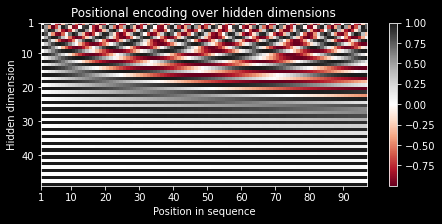

In [325]:

encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

In [327]:
class CosineWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

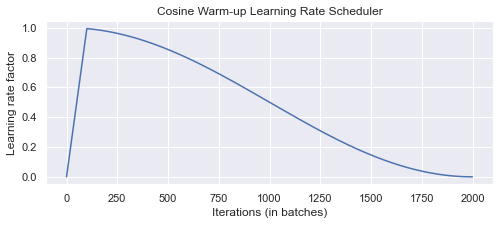

In [330]:
import seaborn as sns
import numpy as np
p = nn.Parameter(torch.empty(4,4))
optimizer = torch.optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()